### Goal 

Compute the crossmatrix (X,Y) where x_ij_k - input and y_ij_l - target, for individual i, individual j, and tissues k,l where k <> l 

### TODO

1. Compute cross matrix
2. Visualize targets by tissue 
3. PCA over features, with n_components=50

### Conclusions
1. These will be stored under `/s/project/rep/processed/gtex/input_data/` as `X_inputs.h5`, `Y_targets.h5` containing:
    - relative expression changes with respect to the mean X_inputs.X, Y_targets.X
    - samples metadata, i.e. X_inputs.samples, Y_targets.samples, where the `Type` column stands for `train, valid, test`
    - features (genes) metadata, i.e. X_inputs.genes, Y_targets.genes

2. We do observe that for the following tissues we should have good predictions: Cells - Transformed fibroblasts, Skin, Muscle, Esophagus/Stomach/Colon.

3. Redundancy affects very heavily the PCA if we use the large crossmatrix as input for the PCA. Instead we will do the PCA over the non-redundant set.


In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import h5py
import anndata

from rep import preprocessing_new as p

import plotly
import plotly.plotly as py
from plotly.graph_objs import graph_objs

# set credentials
plotly.tools.set_credentials_file(username='gium', api_key='nUFs5UnmuBR3pEbGIMj8')

import warnings; warnings.simplefilter('ignore')

### 1. Compute cross matrix

In [3]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.RepAnnData.read_h5ad(file)

# load invidivudals
path = os.path.join("..","..","data","processed","gtex","recount")
train, valid, test = [], [], []
states = ['train','valid','test']
dict_states_indiv = {'train':train,'valid':valid,'test':test}

for s in states:
    with open(os.path.join(path,s+"_individuals.txt"), 'r') as f:
        for l in f: dict_states_indiv[s].append(l.replace("\n",""))


selected_genes = gtex.genes_names # training with all features
print("Total Genes: ",len(selected_genes))


Total Genes:  19932


In [4]:
(X_inputs, Y_targets) =  p.rnaseq_train_valid_test(gtex,dict_states_indiv,selected_genes,onlyBlood=True)
# save inputs and targets
path = os.path.join("..","..","data","processed","gtex","input_data")
X_inputs.save(os.path.join(path,'X_inputs_pc_onlyblood.h5'))
Y_targets.save(os.path.join(path,'Y_targets_pc_onlyblood.h5'))

compute all arrangements
Total pairs: 4403
compute all arrangements
Total pairs: 1630
compute all arrangements
Total pairs: 1558


... storing 'Individual' as categorical
... storing 'Indiv_Seq_Assay' as categorical
... storing 'From_sample' as categorical
... storing 'Gender' as categorical
... storing 'From_tissue' as categorical
... storing 'From_parent_tissue' as categorical
... storing 'To_tissue' as categorical
... storing 'To_parent_tissue' as categorical
... storing 'To_sample' as categorical
... storing 'Type' as categorical


'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/data/processed/gtex/input_data/Y_targets_pc_onlyblood.h5'

In [19]:
%time (X_inputs, Y_targets) =  p.rnaseq_train_valid_test(gtex,dict_states_indiv,selected_genes,onlyBlood=False)
# save inputs and targets
path = os.path.join("..","..","data","processed","gtex","input_data")
X_inputs.save(os.path.join(path,'X_inputs_pc.h5'))
Y_targets.save(os.path.join(path,'Y_targets_pc.h5'))

compute all arrangements
Total pairs: 105778
compute all arrangements
Total pairs: 34830
compute all arrangements
Total pairs: 31308
CPU times: user 1h 57min 53s, sys: 5min 47s, total: 2h 3min 40s
Wall time: 2h 2min 49s


... storing 'Individual' as categorical
... storing 'Indiv_Seq_Assay' as categorical
... storing 'From_sample' as categorical
... storing 'Gender' as categorical
... storing 'From_tissue' as categorical
... storing 'From_parent_tissue' as categorical
... storing 'To_tissue' as categorical
... storing 'To_parent_tissue' as categorical
... storing 'To_sample' as categorical
... storing 'Type' as categorical


'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/data/processed/gtex/input_data/Y_targets_pc.h5'

### 2. Visualize targets by tissue 

In [6]:
import scanpy.api as sc
sc.logging.print_versions()

scanpy==1.3.7 anndata==0.6.16 numpy==1.15.0 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [7]:
top_tissues = ['Muscle - Skeletal','Skin - Sun Exposed (Lower leg)', 'Adipose - Subcutaneous','Lung', 'Artery - Tibial','Thyroid','Nerve - Tibial','Esophagus - Mucosa','Cells - Transformed fibroblasts']

file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data","X_inputs_pc_onlyblood.h5")
inputs = p.RepAnnData.read_h5ad(file)

file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data","Y_targets_pc_onlyblood.h5")
targets = p.RepAnnData.read_h5ad(file)

# subset train data
X_train_inputs = inputs[inputs.samples['Type'] == 'train']
Y_train_targets = targets[targets.samples['Type'] == 'train']

In [8]:
train_individuals = X_train_inputs.obs['Individual'].tolist()

In [9]:
np.min(Y_train_targets.X)

ArrayView(-8., dtype=float32)

#### 2.1 What are we trying to predict?

In [10]:
# plot what we are trying to predict
Y_train_targets_toptissue = sc.tl.pca(Y_train_targets[Y_train_targets.obs['To_tissue'].isin(top_tissues) ], copy=True)

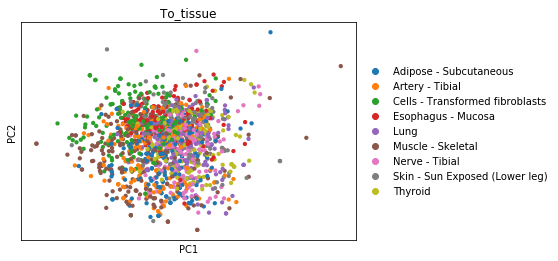

In [11]:
# sc.pl.pca_scatter(Y_train_targets_toptissue, color='To_tissue',components=['1,2','2,3','3,4'])
sc.pl.pca_scatter(Y_train_targets_toptissue, color='To_tissue',components=['1,2'])

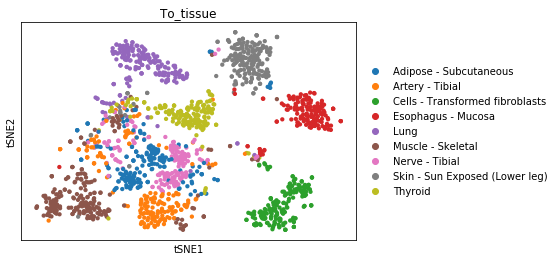

In [12]:
sc.tl.tsne(Y_train_targets_toptissue)
sc.pl.tsne(Y_train_targets_toptissue, color='To_tissue')

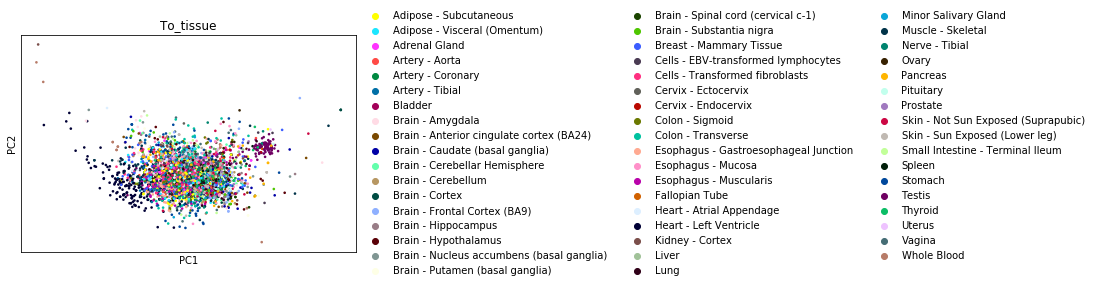

In [13]:
Y_train_targets =  sc.tl.pca(Y_train_targets, copy=True)
sc.pl.pca_scatter(Y_train_targets, color='To_tissue',components=['1,2'])

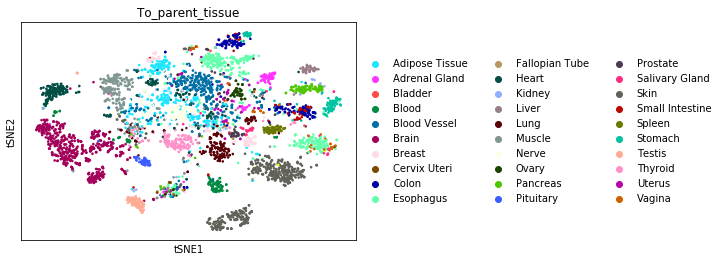

In [14]:
sc.tl.tsne(Y_train_targets)
sc.pl.tsne(Y_train_targets, color='To_parent_tissue')

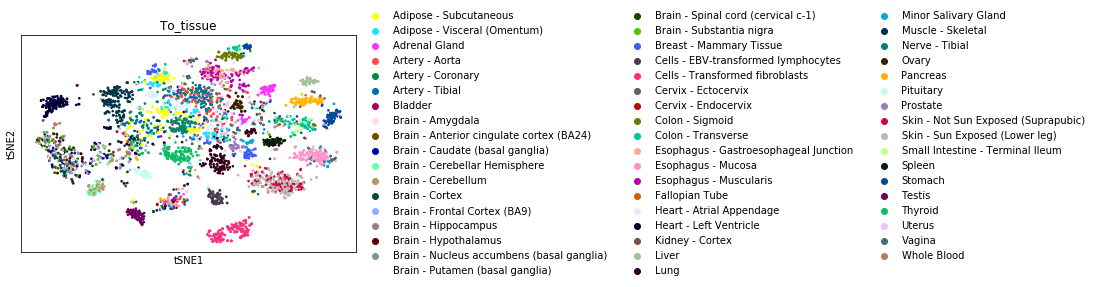

In [15]:
sc.pl.tsne(Y_train_targets, color='To_tissue')

### 3. PCA over features, with n_components=50

In [16]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.load(file)
gtex_filtered = gtex[gtex.obs['Individual'].isin(train_individuals)]
gtex_blood = gtex_filtered[gtex_filtered.obs['Tissue'] == 'Whole Blood']

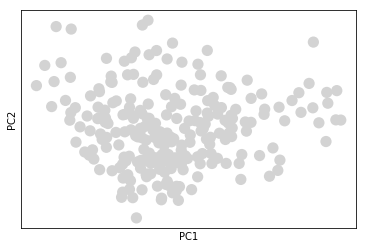

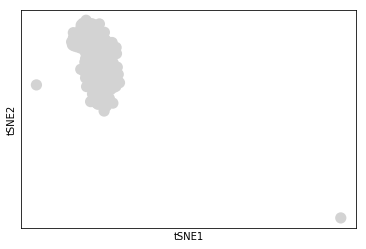

In [17]:
sc.tl.pca(gtex_blood)
sc.pl.pca_scatter(gtex_blood,components=['1,2'])
sc.tl.tsne(gtex_blood)
sc.pl.tsne(gtex_blood)

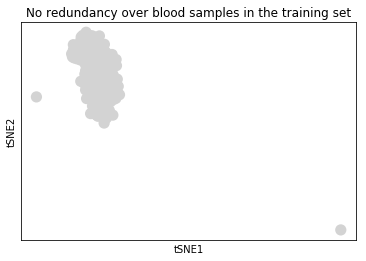

         Falling back to preprocessing with `sc.pp.pca` and default params.


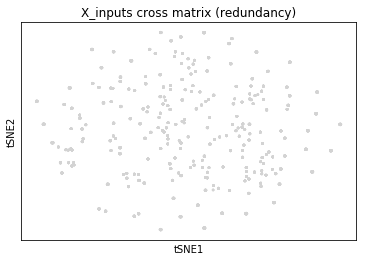

In [18]:
sc.tl.tsne(gtex_blood)
sc.pl.tsne(gtex_blood, title="No redundancy over blood samples in the training set")

sc.tl.tsne(X_train_inputs)
sc.pl.tsne(X_train_inputs,title = "X_inputs cross matrix (redundancy)")

OLD - calling

In [2]:
def cross(norm_gtex):
    # load invidivudals
    path = os.path.join("..","..","data","processed","gtex","recount")

    train = []
    valid = []
    test = []
    states = ['train','valid','test']
    dict_states_indiv = {'train':train,'valid':valid,'test':test}

    for s in states:
        with open(os.path.join(path,s+"_individuals.txt"), 'r') as f:
            for l in f: dict_states_indiv[s].append(l.replace("\n",""))


    selected_genes = norm_gtex.obs_names # training with all features
    print("Total Genes: ",len(selected_genes))

    # compute cross tissue matrix
    (X_train_norm, Y_train_norm, samples_description_train, gene_id_train, metadata_train) = p.rnaseq_cross_tissue(norm_gtex, individuals=train, gene_ids=selected_genes, onlyBlood = True)
    (X_valid_norm, Y_valid_norm, samples_description_valid, gene_id_valid, metadata_valid) = p.rnaseq_cross_tissue(norm_gtex, individuals=valid, gene_ids=selected_genes, onlyBlood = True)
    (X_test_norm, Y_test_norm, samples_description_test, gene_id_test, metadata_test) = p.rnaseq_cross_tissue(norm_gtex, individuals=test, gene_ids=selected_genes, onlyBlood = True)
    
    return  (X_train_norm, Y_train_norm, samples_description_train, gene_id_train, metadata_train), (X_valid_norm, Y_valid_norm, samples_description_valid, gene_id_valid, metadata_valid), (X_test_norm, Y_test_norm, samples_description_test, gene_id_test, metadata_test)

In [4]:
file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.load(file)
(X_train, Y_train, samples_description_train, gene_id_train, metadata_train), (X_valid, Y_valid, samples_description_valid, gene_id_valid, metadata_valid), (X_test, Y_test, samples_description_test, gene_id_test, metadata_test) = cross(gtex)

Total Genes:  19932
compute all arrangements
Total pairs: 4403
compute all arrangements
Total pairs: 1630
compute all arrangements
Total pairs: 1558


In [5]:
# save
path = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data")

p.writeh5(X_train,"X_train",os.path.join(path,"X_train_pc_bloodonly.h5"))
p.writeh5(Y_train,"Y_train",os.path.join(path,"Y_train_pc_bloodonly.h5"))
p.writeh5(X_valid,"X_valid",os.path.join(path,"X_valid_pc_bloodonly.h5"))
p.writeh5(Y_valid,"Y_valid",os.path.join(path,"Y_valid_pc_bloodonly.h5"))
p.writeh5(X_test,"X_test",os.path.join(path,"X_test_pc_bloodonly.h5"))
p.writeh5(Y_test,"Y_test",os.path.join(path,"Y_test_pc_bloodonly.h5"))

p.writeJSON(metadata_train,os.path.join(path,"XY_metadata_train_pc_bloodonly.json"))
p.writeJSON(metadata_valid,os.path.join(path,"XY_metadata_valid_pc_bloodonly.json"))
p.writeJSON(metadata_test,os.path.join(path,"XY_metadata_test_pc_bloodonly.json"))

In [6]:
dict = {}
dict['train'] = {'samples':samples_description_train,'genes':gene_id_train.tolist()}
dict['valid'] = {'samples':samples_description_valid,'genes':gene_id_valid.tolist()}
dict['test'] = {'samples':samples_description_test,'genes':gene_id_test.tolist()}
p.writeJSON(dict,os.path.join(path,'metadata.json'))